#DT2470 Lab 03: Shazam Wow!

by Bob |. Sturm

In this lab you will build and test a music fingerprinting system, similar to how Shazam does it – or at least as described in 2003: A. Wang, “An industrial strength audio search algorithm,” in Proc. Int. Soc. Music Info. Retrieval, Oct. 2003. Our approach is illustrated below. First we will take an audio signal and compute its time-frequency representation, or sonogram. Then we will strategically find several points of interest in that representation. For each of those points we will construct tuples using other points of interest in the sonogram. These will become hashes that describe the fingerprint of the audio signal.

![fingerprint overview](https://drive.google.com/uc?id=1HcVCkvyhHrKEkvVemr7wufaTHws5FPG8)

In the first part, you will gradually build said fingerprint creation system.

In the second part, you will build an algorithm that compares fingerprints.

The lab report you submit should be a testament to your intelligence, as well as a reflection of your willingness to be a part of this module. You are free to use whatever software you want, e.g., MATLAB, Processing, etc. But below I use python. See the first lab and its solutions for assistance.

I also include some images so you can confirm whether you are on the right track, or just to have a brief pause to laugh at how far your answer is from being correct.


---



In [1]:
# Install a python library for working with audio files, named pydub

!pip install pydub

from google.colab import drive
drive.mount('/content/gdrive/')
root_path_lab03 = '/content/gdrive/My Drive/lab3/queries/queries/'


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).



#Part 1 Creating audio fingerprints

1. Pick one of the query sound files and compute its dB magnitude short-time Fourier transform using a Hann window of duration 50 ms with a window hopsize of 10 ms, and zeropadding to four times the length of the window. Plot said sonogram, and appropriately label your axes with "Frequency (kHz)" and "Time (s)". The frequency axis must be in kiloHertz, and limited 0 to 5000 Hz. The time axis must be in seconds. Choose a colormap that you feel describes your personality (https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html).


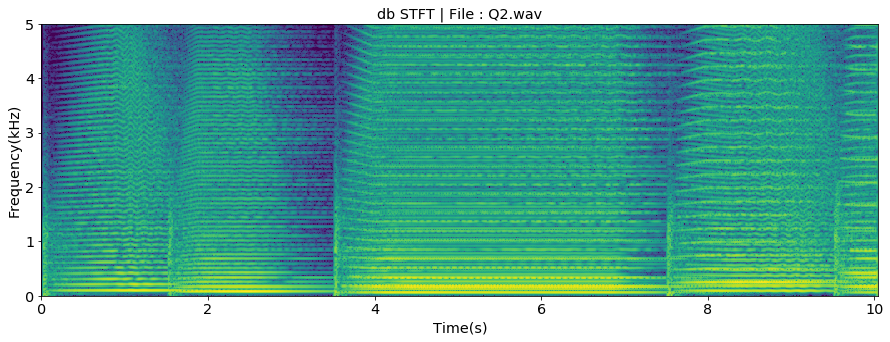

In [2]:
import pydub
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import scipy

# The following makes the plot look nice
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

# write code here


file = 'Q2.wav' #'cretansyrtos.wav'#put your file

sound = pydub.AudioSegment.from_file(root_path_lab03+file,format="wav")
sound = sound.set_channels(1) 
#sound = pydub.effects.normalize(sound) 


window=50 # window size
hop=10  #hop size
pad_length=4*window
#return normalised STFT
samples = sound.get_array_of_samples()
  
samplerate=sound.frame_rate
#samples=samples[0:samplerate]

def applySTFT(samples,window,hop,windowType):
  #window=30# window size in ms

  frame_size = np.ceil((samplerate/1000) * window)
  overlap = np.ceil((samplerate/1000) * (window-hop)) 
  t=len(samples)/samplerate

  signal_padded=np.pad(samples,(pad_length,pad_length),'constant')
  freq, time, stft = scipy.signal.stft(signal_padded, samplerate, nperseg=frame_size,noverlap=overlap,window=windowType)
  norm_stft=np.abs(stft)/np.max(np.abs(stft))
  #time = time / samplerate
  freq = freq / 1000 #* samplerate 
   
  return time,freq,stft,t,samplerate

time,freq,stft,t,fs=applySTFT(samples,window,hop,"hann")
mag = 20 * np.log10(np.abs(stft)/np.max(np.abs(stft)))



plt.pcolormesh(time, freq, mag, vmin=-80, vmax=0, cmap='viridis')#,winter
plt.title('db STFT | File : ' +file)
plt.ylabel('Frequency(kHz)')
plt.xlabel('Time(s)')
plt.ylim(0,5)
plt.show()
   




2. We are now going to locate in this sonogram "anchors", or points of interest. We will take a rather naive approach: for each continguous ΔTxΔF box, find the time and frequency with the largest energy. Let's make ΔT=100 ms, and ΔF be such that it divides the whole spectrum $[0,F_s/2]$ into 25 bands. For each one of these segments, locate the time and frequency of the largest value, as well as its dB. Do this for the sonogram you created in the last question.


In [0]:
# write code here


def anchor(mat,ts,time,freq):
  
 
  frame_rate=len(time)/ts #samples per sec
  delta_t=int((frame_rate/1000)*100)
  delta_fs=int(len(freq)/25)
  index_f=[]
  index_t=[]
  max_freq=[]
  max_time=[]
  indices=[]
  values=[]
  
  for i in range(0, len(freq), delta_fs): 
      for j in range(0, len(time), delta_t):
        window = mat[i:i+delta_fs,j:j+delta_t]    
        index=np.unravel_index(np.argmax(window), window.shape)
        a=[index[0]+i ,index[1]+j]
        indices.append(a)
        index_f.append(a[0])
        index_t.append(a[1])
        b=round(freq[a[0]],2)
        c=round(time[a[1]],2)
        max_freq.append(b)
        max_time.append(c)
        values.append([b,c])
     
  return values,max_freq,max_time 





3.  With the anchors you found in the previous question, superimpose them on the sonogram. Write something intelligent about the results. My figure appears below, with each anchor marked by an "x". ![My scatter plot](https://drive.google.com/uc?id=1sGi29bcTNN7f8NtZ4tjlS6MDUf_fXhcw)

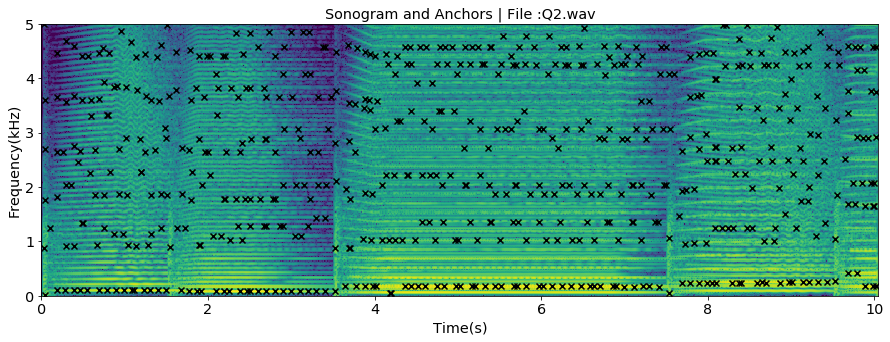

In [4]:
# write code here

values,max_freq,max_time=anchor(mag,t,time,freq)

fig, ax = plt.subplots()
plt.pcolormesh(time, freq, mag, vmin=-80, vmax=0, cmap='viridis')#,
ax.scatter(max_time,max_freq, c='black', marker="x")
plt.title('Sonogram and Anchors | File :' +file)
plt.ylabel('Frequency(kHz)')
plt.xlabel('Time(s)')
plt.ylim(0,5)
ax.set_xlim(left=0,right=np.max(time))
plt.show()
    


4. Now it's time to compute hashes from a set of anchors. A *hash* is a tuple describing an anchor at time ($t_1$) and its relationship to another anchor at time ($t_2$). A Shazam hash is the tuple $(f_1,f_2,∆t_{12})$, which contains the frequencies of both anchors ($f_1$,$f_2$), and the difference in their time positions ($∆t_{12} = t_2-t_1$). The Shazam fingerprint of an audio signal is then the set of hashes extracted from it as well as times at which each hash appears. To create these hashes, Shazam does not look at all pairs of anchors. For a given anchor, it computes hashes using anchors in a "target zone". Define the target zone of an anchor as a time-frequency region 100 ms after $t_1$, spanning 500 ms, and spanning frequencies one half-octave above and below $f_1$. For instance, for an anchor with $t_1$ and $f_1$, its target zone is located between $t_1+100$ ms and $t_1+100+500$ ms, and spans a frequency range of $f_12^{-0.5}$ and $f_12^{0.5}$. Compute all the hashes for your choosen query signal, in the form $(f_1,f_2,∆t_{12})$. Your final data structure representing a fingerprint $F$ should be something like a sequence of times paired with hashes $F = ((\tau_1, h_1), (\tau_2, h_2), \ldots)$, where $\tau_1$ is the time at which hash $h_1$ occurs, etc.

In [0]:
# write code here

def calc_hash(t1,f1,t_list,f_list,hashmap):
 
  for i,f2 in enumerate(f_list):
    t2=t_list[i]
    delta_t=t2-t1   
    k=(f1,f2,delta_t)
    hashmap[k]=t1  
  
  return hashmap



def get_hash(values,max_freq,max_time):

  target_f_s=np.power(2,-0.5)
  target_f_e=np.power(2,0.5)
  m=np.vstack((max_freq,max_time))
  freq=m[0]
  time=m[1]
  hashmap={}
    

  for i,v in enumerate(values):
    f1=v[0]
    t1=v[1]
    t_s=t1+0.1
    t_e=t1+0.5
    f_s=f1*target_f_s
    f_e=f1*target_f_e
 
    x=np.where((time>=t_s) & (time<=t_e) & (freq>= f_s) & (freq <= f_e))
    t=time[x[0]]
    f=freq[x[0]]
    hashmap=calc_hash(t1,f1,t,f,hashmap)
  
  return hashmap
  
#get hashes  
map_hash=get_hash(values,max_freq,max_time)

  
 


#Part 2 Comparing fingerprints

5. Now it's time to create an algorithm for comparing two fingerprints. We will start simple to make sure things work. Extract any 1-second segment of from the audiofile you worked with above and compute its fingerprint $F_q$ as above. ("q" is for "query".) Now for each hash in $F_q$, find all matching hashes in $F_q$, and store the times of the matches. To compare two hashes, compute the sum of the magnitude differences between the dimensions of the hashes. For instance, if I have these hashes, $(a,b,c)$ and $(d,e,f)$, I just compute the following value: $d = |(a-d)+(b-e)+(c-f)|$. If $d=0$ then it's a match! Create a scatter plot of the times of the matching hashes. Write something about what you see, and why you see it. Not why you see it, but *why* you see the properties you see in this particular plot. My plot looks like this: ![My scatter plot](https://drive.google.com/uc?id=1nIwTLYPFM64VAkt8hsfG9WMiXzFNAJjq) 



In [0]:

#compare hash based on keys of dictionary
def compareMap(map1,map2):
  m1=[]
  m2=[]
  
  
  for key1 in map1:
    #print(key1)
    f1=key1[0]
    f2=key1[1]
    dt1=key1[2]
    
    if key1 in map2.keys():    ### this is very fast but does not calculate difference magnitude
      
      m1.append(map1[key1])
      m2.append(map2[key1])
     
    ###this is very slow but calculates difference magnitude
    
    """  
    for key2 in map2: 
      #print(key2)
      f2_1=key1[0]
      f2_2=key1[1]
      dt2=key1[2]
      
      n=np.absolute((f1-f2_1)+(f2-f2_2)+(dt1-dt2))
      if n==0:
        m1.append(map1[key1])
        m2.append(map2[key1])
        
     
      """     
  
  return m1,m2




In [0]:
#file2 = 'Q1.wav' #'cretansyrtos.wav'#put your file
#window=50 # window size
#hop=10  #hop size

start=1000 #start of segment in ms
end=2000 # end of segment in ms
#sound2 = pydub.AudioSegment.from_file(root_path_lab03+file2,format="wav")
#sound2 = sound2.set_channels(1)
sound2 =sound[start:end]
samples2 = sound2.get_array_of_samples() 
samplerate2=sound2.frame_rate
#pad_length=4*window
#signal_padded=np.pad(samples3,(pad_length,pad_length),'constant')

time_s,freq_s,stft_s,t_s,fs=applySTFT(samples2,window,hop,"hann")
mag_s = 20 * np.log10(np.abs(stft_s)/np.max(np.abs(stft_s)))

values_s,max_freq_s,max_time_s= anchor(mag_s,t_s,time_s,freq_s)

map_hash_q=get_hash(values_s,max_freq_s,max_time_s)

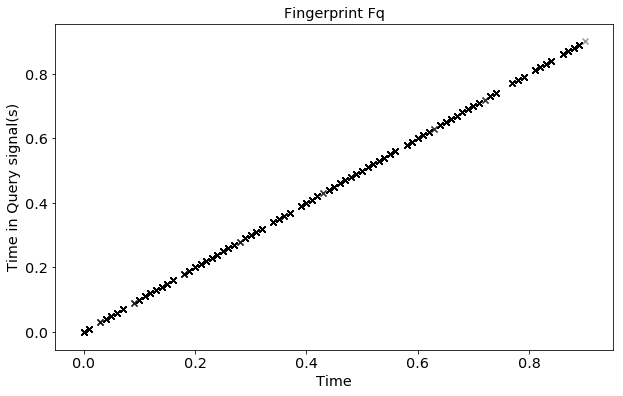

In [8]:
#compare Fq
t1,t2=compareMap(map_hash_q,map_hash_q)


#plpot
params = {'figure.figsize': (10, 6) }
plt.rcParams.update(params)

fig, ax = plt.subplots()

ax.scatter(t1,t2, c='black', marker="x",alpha=0.4)
plt.title('Fingerprint Fq')
plt.ylabel('Time in Query signal(s)')
plt.xlabel('Time')
#plt.ylim(0,5)
#ax.set_xlim(left=0,right=np.max(time))
plt.show()
            


**Answers**

We take Q2.wav file and create the hash document file and also a query file between 1 to 2 second segment .We observe that the plot follows a diagonal line along two time axis.Since we are comparing the hashes of same time segment length and file we see that all samples match leading to a diagonal plot ,meaning high similarity.Also in my plot I do not see any off diagonal plots which is because I directly equated the hashes as key of dictionaries to get a match instead of calculating a magnitude differennce.This could lead to some points being missed but it works significantly faster and we see still the important structural properties ,which could be more important than individual match points.

6. Now compare $F_q$ with $F_d$, where $F_d$ is the fingerprint of the original audiofile. ("d" is for "document") Again make a scatter plot of the times of the matches. As above, write something about the results.

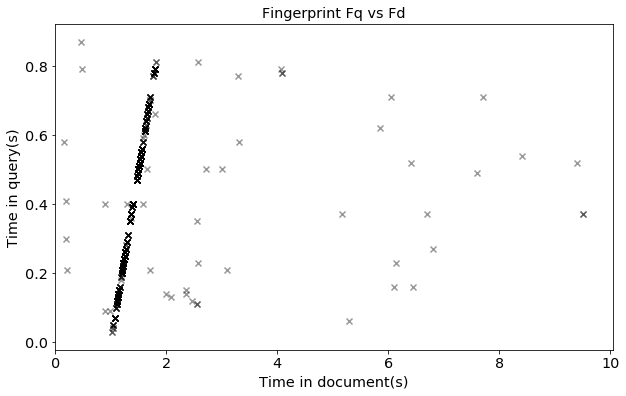

In [9]:
# write code here
#compare with complete file
tc1,tc2=compareMap(map_hash,map_hash_q)


#plot
fig, ax = plt.subplots()

ax.scatter(tc1,tc2, c='black', marker="x",alpha=0.4)
plt.title('Fingerprint Fq vs Fd')
plt.ylabel('Time in query(s)')
plt.xlabel('Time in document(s)')

ax.set_xlim(left=0,right=np.max(time))
plt.show()    
  

**Answer**

THis time we take the 1 second segment between 1 to 2 secs and compare with the whole document.We observe a diagonal plot exactly between 1 to 2 sec of the document .This means a high degree of similarity between the two axes indicating that our query signal of length 1 second matches the period of 1 to 2 seconds of our document file.We also see other scattered points which could mean the same hashes exists in different time instances of the complete document but are very few.Therefore even with short a query segment of 1 second we can identify our query based on its fingerprint hashes.

7. Finally compare $F_q$ with $F_d$, where $F_d$ is the fingerprint of a *different* audiofile. Again make a scatter plot of the times of the matches. As above, write something about the results, and in particular compare with the plot produced in the l

In [0]:
# write code here


file3 = 'Q6.wav' #'cretansyrtos.wav'#put your file
window=50 # window size
hop=10  #hop size

#start=1000 #start of segment in ms
#end=2000 # end of segment in ms
sound3 = pydub.AudioSegment.from_file(root_path_lab03+file3,format="wav")
sound3 = sound3.set_channels(1)
#sound3 =sound3[start:end]
samples3 = sound3.get_array_of_samples() 
samplerate3=sound3.frame_rate
#pad_length=4*window
#signal_padded=np.pad(samples3,(pad_length,pad_length),'constant')

time_x,freq_x,stft_x,t_x,fs=applySTFT(samples3,window,hop,"hann")
mag_x = 20 * np.log10(np.abs(stft_x)/np.max(np.abs(stft_x)))

values_x,max_freq_x,max_time_x= anchor(mag_x,t_x,time_x,freq_x)

map_hash_n=get_hash(values_x,max_freq_x,max_time_x)




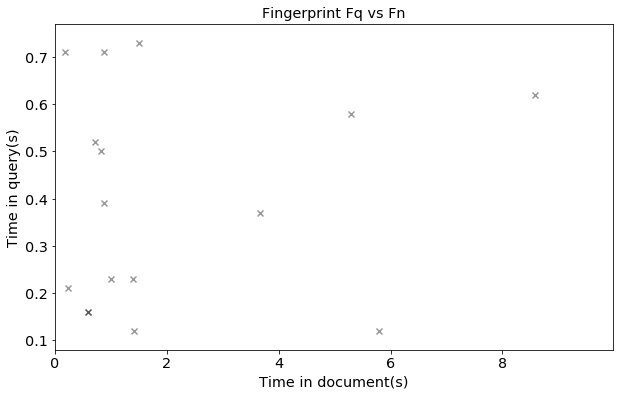

In [11]:
#compare with different file
tx1,tx2=compareMap(map_hash_n,map_hash_q)


#plot
fig, ax = plt.subplots()
ax.scatter(tx1,tx2, c='black', marker="x",alpha=0.4)
plt.title('Fingerprint Fq vs Fn')
plt.ylabel('Time in query(s)')
plt.xlabel('Time in document(s)')

ax.set_xlim(left=0,right=np.max(time_x))
plt.show()  



**Answer**

This time we compare the finger print of query signal file Q1 to the document file Q6.We do not find any pattern in the plot indicating similarity betweeen the two and only see a few matching hashes.THis is also justified after listening to both audio files which are very different to sound.THis validates that our hashes of spectral peak features have high specificity with which we can identify a query file of small durations of even 1 secound.Also with hashes we also reduce our search algorithm complexity instead of searching based only on spectral peak anchors. 
